### Example of SuperCTM Model
- In SuperCTM, you can label the documents to aid the clustering
- One way would be to utilise the pre-provided categories (used here)
- One could also label a subset of data by hand as a seed data

### CTM Model Training

In [1]:
### GENERAL VARIABLES:
sample_size = 100
epochs = 10

#What categories to use, either main/10 or sub_cat/43 if you want proper fit for comparison
#This is really for the extra stuff at the end
topics = 10
compare_to = "main_category" #main_category#sub_category

In [2]:
from contextualized_topic_models.models.ctm import CombinedTM
from contextualized_topic_models.utils.data_preparation import TopicModelDataPreparation
from contextualized_topic_models.utils.preprocessing import WhiteSpacePreprocessingStopwords
import nltk
import pandas as pd

In [3]:
import sys
sys.path.append("../")
from src import puhti_files

In [ ]:
### Load in data
#df = puhti_files.genre_data_to_pandas(data="train", add_labels=True, merge_ecco=True, better_subcat_names=True)

In [ ]:
#Sample data, ensure that every category is represented

#import math
#n_categories = len(df[compare_to].unique())
#take_per_category = math.ceil(sample_size / n_categories)


# Group by sub_category and take one random sample from each group
#df = df.groupby(compare_to, group_keys=False).apply(lambda x: x.sample(take_per_category, replace=True))
#df = df.drop_duplicates()

#print(len(df[compare_to].unique()))
#print(len(df))

In [ ]:
### Read in texts
#df["text"] = df["document_id"].apply(lambda x: puhti_files.read_text_file(x))
#df.head(3)

In [4]:
df = pd.read_csv("df_valivaihe.csv")
df.head(3)

,document_id,work_id,main_category,sub_category,main_category_label,sub_category_label,publication_year,gatherings,publication_place,author_id,...,ecco_languge,ecco_nr_paragraphs,ecco_id_y,document_part_type,document_part_number,document_part_id,document_part_nr_characters,document_part_nr_tokens,text,clean_t
0,1195800100,198-recruiting officer,0,0,Arts,"Theatre, plays, opera",1727,8vo,Dublin,61545511,...,English,665.0,1195800100,body,3.0,467077.0,134667.0,23681.0,the recruiting officer. a comed y. written by ...,recruiting officer comed written mr. q.u capti...
1,579400903,174-lucubrations of isaac bickerstaff,2,18,Literature,Other fiction,1723,12mo,London,7413288,...,English,1643.0,579400903,body,3.0,438523.0,646182.0,117037.0,"i t h e, the lucubrations o f isaac ickc rfl i...",lucubrations isaac ickc rfl esq i-i/ aed co'.c...
2,1416900800,116-orphan or unhappy marriage,2,4,Literature,Drama,1722,12mo,London,56618493,...,English,943.0,1416900800,body,4.0,734739.0,87376.0,16295.0,".g-~tze envy ~culjl: ~ th e: y- orphane ·or, t...",.g-~tze envy ~culjl orphane ·or ppy~ rriage.l ...


In [5]:
df = df[df["decade"]==1720]
df['decade'].value_counts()

1720    800
Name: decade, dtype: int64

In [6]:
df["text"] = df["clean_t"]

In [7]:
### Create dataset with splitted documents. Document_id is kept for later merge.

def split_text(text, num_words):
    words = text.split()
    chunks = [' '.join(words[i:i + num_words]) for i in range(0, len(words), num_words)]
    return chunks

num_words = 128
split_data = []
for _, row in df.iterrows():
    doc_id = row['document_id']
    main_category_label = row["main_category_label"]
    sub_category_label = row["sub_category_label"]
    
    text = row['text']
    chunks = split_text(text, num_words)
    
    for chunk in chunks:
        split_data.append({
            'document_id': doc_id,
            "main_category_label": main_category_label,
            "sub_category_label": sub_category_label,
            'text': chunk
        })

split_df = pd.DataFrame(split_data)
len(split_df)

317625

In [8]:
from nltk.corpus import stopwords as stop_words
nltk.download('stopwords')
stopwords = list(stop_words.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     /users/tturpein/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
sp = WhiteSpacePreprocessingStopwords(list(split_df["text"]), stopwords_list=stopwords, vocabulary_size=2000)#vocabulary_size=2000
preprocessed_documents, unpreprocessed_corpus, vocab, retained_indices = sp.preprocess()
print(len(preprocessed_documents))
print(len(unpreprocessed_corpus))

317552
317552


In [10]:
# We use "_label" column as labels.
# I'm not sure if the actual names really matter. Could be that you can use numeric ones.
labels = split_df[compare_to + "_label"].to_numpy()

In [11]:
#We have to drop the labels for the rows that the preprocessing drops
labels = labels[retained_indices]
labels = list(labels)
len(labels)

317552

In [12]:
tp = TopicModelDataPreparation("paraphrase-multilingual-mpnet-base-v2")

training_dataset = tp.fit(
    text_for_contextual = unpreprocessed_corpus,
    text_for_bow = preprocessed_documents,
    labels = labels
)

Batches:   0%|          | 0/1588 [00:00<?, ?it/s]

In [13]:
### Checking how labels are encoded
### They should be one-hotted
training_dataset.__getitem__(0)["labels"]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [14]:
### Training the model with labels

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false" # Gets rid of warnings

ctm = CombinedTM(
    bow_size=len(tp.vocab),
    contextual_size=768,
    n_components=topics,
    num_epochs=epochs,
    label_size=len(set(labels))
)

In [15]:
ctm.fit(training_dataset)

/users/tturpein/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch: [10/10]	 Seen Samples: [3175040/3175520]	Train Loss: 451.26272710958955	Time: 0:00:43.988905: : 10it [07:28, 44.81s/it]
100%|██████████| 4962/4962 [00:42<00:00, 116.73it/s]


In [16]:
### Topic predictions as percentages for each topic for each document chunk

topics_predictions = ctm.get_thetas(training_dataset, n_samples=5)
topics_predictions.shape

100%|██████████| 4962/4962 [00:34<00:00, 143.43it/s]


(317552, 10)

### Comparing to premade categories
- The rest of the code is just a accuracy comparison to the older categories

In [17]:
### Adding the predictions to a dataframe
topic_columns = [f"topic_{i}_prob" for i in range(0, topics)]
predictions_df = pd.DataFrame(topics_predictions, columns=topic_columns)

In [18]:
### !!!NOTE: Because of dropped rows, the precictions dataframe doesn't match split_df
### retained_indices has the actual indices of the data. We use that to reset the index after which we can concat correctly

#Resetting the index 
predictions_df = predictions_df.set_index(pd.Index(retained_indices))
split_df = pd.concat([split_df, predictions_df], axis=1)
split_df.shape

(317625, 14)

In [19]:
### Calculate mean probability from chunks for each document
### Then take the best probability as 'best_topic'
### This reduces the dataframe back to 1 document_id per row

mean_prob_df = split_df.groupby('document_id')[topic_columns].mean()
mean_prob_df['best_topic'] = mean_prob_df.idxmax(axis=1).str.replace('_prob', '').str.replace('topic_', '').astype(int)
print(len(mean_prob_df))
mean_prob_df.head(3)

800


,topic_0_prob,topic_1_prob,topic_2_prob,topic_3_prob,topic_4_prob,topic_5_prob,topic_6_prob,topic_7_prob,topic_8_prob,topic_9_prob,best_topic
document_id,,,,,,,,,,,
4400100,0.055631,0.053654,0.059722,0.058051,0.040165,0.055755,0.091606,0.121337,0.403266,0.060813,8
6101100,0.085226,0.056686,0.058869,0.051628,0.061046,0.056303,0.402044,0.061988,0.099089,0.067122,6
6101201,0.103784,0.083905,0.071664,0.074327,0.117396,0.081974,0.207942,0.074931,0.083812,0.100265,6


In [20]:
### Finally merge to original dataframe
df = pd.merge(df, mean_prob_df, on='document_id', how='left')
df.head(3)

,document_id,work_id,main_category,sub_category,main_category_label,sub_category_label,publication_year,gatherings,publication_place,author_id,...,topic_1_prob,topic_2_prob,topic_3_prob,topic_4_prob,topic_5_prob,topic_6_prob,topic_7_prob,topic_8_prob,topic_9_prob,best_topic
0,1195800100,198-recruiting officer,0,0,Arts,"Theatre, plays, opera",1727,8vo,Dublin,61545511,...,0.037062,0.039070,0.076677,0.049224,0.042866,0.537826,0.067137,0.039655,0.064862,6
1,579400903,174-lucubrations of isaac bickerstaff,2,18,Literature,Other fiction,1723,12mo,London,7413288,...,0.075844,0.073393,0.105498,0.051434,0.147614,0.191019,0.086818,0.082620,0.074129,6
2,1416900800,116-orphan or unhappy marriage,2,4,Literature,Drama,1722,12mo,London,56618493,...,0.052011,0.040255,0.069684,0.117028,0.055245,0.188835,0.056901,0.046767,0.326984,9


In [23]:
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [24]:
cm = confusion_matrix(df[compare_to], df['best_topic'])
cm

array([[  0,   0,   0,   1,   8,   0,  61,   0,   0,  46],
       [ 31,   0,   0,   4,   0,   0,   0,   0,   0,   0],
       [ 10,   0,   0,  10,   7,  16,  95,   6,  13, 148],
       [  1,   1,   0,   0,   0,   5,   1,   0,   0,   1],
       [  4,   1,   1,   5,   0,   0,   7,  20,  54,   2],
       [  0,   4,  30,  22,   0,   0,   0,   1,   0,   0],
       [  0,   0,   0,   0,   0,   0,   4,   1,   0,   3],
       [  0,   3,   6,   0,   0,   0,   0,   5,   8,   3],
       [  0,   3,   0,   1,   0,  33,   2,   0,   4,   0],
       [  2,  46,   0,  11,  40,   0,   9,   0,   0,   0]])

In [25]:
# Find the best mapping
best_mapping = np.argmax(cm, axis=0)
best_mapping

array([1, 9, 5, 5, 9, 8, 2, 4, 4, 2])

In [26]:
mapping_dict = {i: category for i, category in enumerate(best_mapping)}
mapping_dict
len(mapping_dict)

10

In [27]:
df['best_fit_category'] = df['best_topic'].map(mapping_dict)

In [28]:
accuracy = accuracy_score(df['main_category'], df['best_fit_category'])
accuracy

0.64875

In [29]:
predicted_topic_labels = {1720: {1: 'Kings',
  2: 'Verbs?/War?',
  3: 'Goverment/Royal',
  4: 'Romance',
  5: 'Law',
  6: 'Prayer/Bible',
  7: 'Social',
  8: 'War?',
  9: 'Religion',
  10: 'Science'},
 1730: {1: 'Locations/People',
  2: 'Social Concepts',
  3: 'State',
  4: 'Religion',
  5: 'Bigger Concepts',
  6: 'Kings',
  7: 'Religion',
  8: 'Nature',
  9: 'Goverment/Kingdom',
  10: 'Romance'},
 1740: {1: 'War/Kingdom',
  2: 'Religion',
  3: 'NA?',
  4: 'Law',
  5: 'Religion',
  6: 'Nature',
  7: 'Romance',
  8: 'Romance',
  9: 'Royalty',
  10: 'Philosophy'},
 1750: {1: 'Kingdom',
  2: 'NA',
  3: 'Romance/Religion',
  4: 'Religion',
  5: 'NA',
  6: 'Country/Issues',
  7: 'Kingdom',
  8: 'Mankind',
  9: 'Bible/Religion',
  10: 'Nature'},
 1760: {1: 'Love/Family',
  2: 'Nature',
  3: 'Love/Religious Concepts',
  4: 'Kingdom',
  5: 'Bible/Religion',
  6: 'Religion',
  7: 'Government affairs',
  8: 'NA',
  9: 'State Affairs',
  10: 'Philosophy'},
 1770: {1: 'NA',
  2: 'Law/Court',
  3: 'Love/Religion',
  4: 'Kingdom',
  5: 'Mankind',
  6: 'Love',
  7: 'Higher Power',
  8: 'Kingdom/War',
  9: 'Nature',
  10: 'Church/Religion'},
 1780: {1: 'NA',
  2: 'War',
  3: 'Law',
  4: 'Mandkind',
  5: 'Romance',
  6: 'Medicine',
  7: 'Religion',
  8: 'Prayer/Bible',
  9: 'Trade/Economy',
  10: 'Court/Kingdom'},
 1790: {1: 'NA',
  2: 'Love',
  3: 'Law',
  4: 'Parliament',
  5: 'Literature?',
  6: 'Romance',
  7: 'Religion',
  8: 'Countries/Land/Economy',
  9: 'Ingredients?',
  10: 'Mankind'}}

In [32]:
labels = puhti_files.labels_to_dict(invert=False)
labels['main2id']

{'Arts': 0,
 'Scientific Improvement': 1,
 'Literature': 2,
 'Education': 3,
 'History': 4,
 'Law': 5,
 'Sales Catalogues': 6,
 'Politics': 7,
 'Philosophy': 8,
 'Religion': 9}

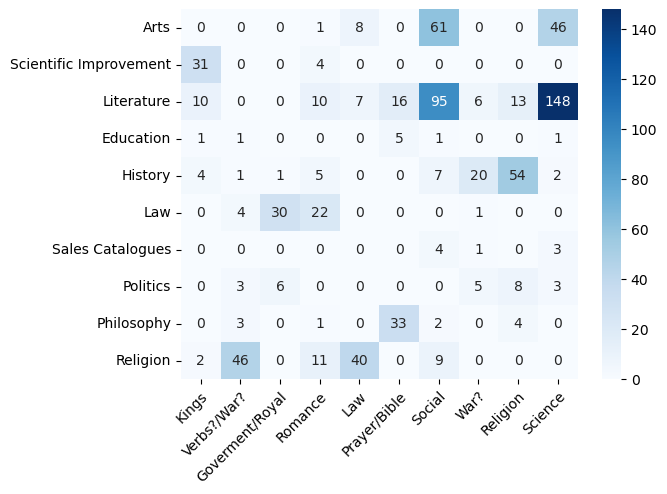

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you already have 'cm' as your confusion matrix from previous steps

# Create a heatmap of the confusion matrix

ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(predicted_topic_labels[1720].values()), yticklabels=list(labels['main2id'].keys()))

plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

plt.show()

In [34]:
predicted_labels_1720 = list(predicted_topic_labels[1720].values())
predicted_labels_1720[4] = "Law (new)"
predicted_labels_1720[8] = "Religion (new)"
old_labels = list(labels['main2id'].keys())
label_map = {predicted_labels_1720[key]: old_labels[value]  for key, value in mapping_dict.items()}

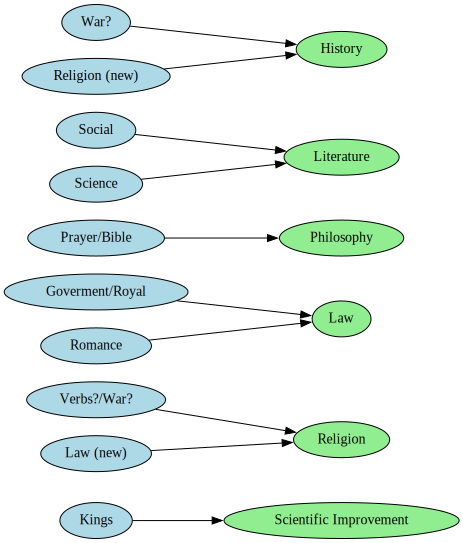

In [35]:
import pydot
from IPython.display import SVG

# Assuming you have 'mapping_dict' from previous steps

# Create a directed graph
graph = pydot.Dot(graph_type='digraph', rankdir='LR', splines='polyline')

# Add nodes and edges based on the mapping dictionary
for predicted_topic, ground_truth_category in label_map.items():
    # Create nodes
    predicted_node = pydot.Node(f"{predicted_topic}", style='filled', fillcolor='lightblue')
    ground_truth_node = pydot.Node(f"{ground_truth_category}", style='filled', fillcolor='lightgreen')

    # Add nodes to the graph
    graph.add_node(predicted_node)
    graph.add_node(ground_truth_node)

    # Create and add edge
    edge = pydot.Edge(predicted_node, ground_truth_node)
    graph.add_edge(edge)

# Visualize the graph
svg = SVG(graph.create_svg())
display(svg)